In [1]:
#Installing scikit-image
!pip install scikit-image
!pip install seaborn_image

  Using cached decorator-4.4.2-py2.py3-none-any.whl (9.2 kB)
  Attempting uninstall: decorator
    Found existing installation: decorator 5.0.6
    Not uninstalling decorator at /shared-libs/python3.7/py-core/lib/python3.7/site-packages, outside environment /root/venv
    Can't uninstall 'decorator'. No files were found to uninstall.
  Using cached importlib_metadata-1.7.0-py2.py3-none-any.whl (31 kB)
  Using cached decorator-4.4.2-py2.py3-none-any.whl (9.2 kB)
  Attempting uninstall: decorator
    Found existing installation: decorator 5.0.6
    Not uninstalling decorator at /shared-libs/python3.7/py-core/lib/python3.7/site-packages, outside environment /root/venv
    Can't uninstall 'decorator'. No files were found to uninstall.
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 3.10.1
    Not uninstalling importlib-metadata at /shared-libs/python3.7/py-core/lib/python3.7/site-packages, outside environment /root/venv
    Can't uninstall 'im

In [2]:
# imports 
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image 
import sys
import pandas as pd
from skimage import morphology
sys.path.insert(1, 'fyp2021p3') # needed to import module from subfolder
import seaborn as sbn
import seaborn_image as sbnim
from skimage import transform
from sklearn import preprocessing

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score

from skimage.feature import local_binary_pattern
from skimage.color import label2rgb
from skimage.color import rgb2gray
from skimage.segmentation import slic
from skimage.util import img_as_float


%run -i fyp2021p3g12/fyp2021p3_group00_functions.py

# Task 0

In [3]:
## CONSTANTS
BASE_DIR = "fyp2021p3g12/data/"
file_features = "fyp2021p3g12/features/features.csv"


<p>The data we have been given consists of a folder containing a slice of the images (and some superpixels) from the ISIC 2017 dataset. Furthermore, it contains a folder with the images' segmentation, a csv file with the diagnoses of the lesions and a csv file containing the area and perimeter for each of the lesions.</p>


In [4]:
## loading the data
data = pd.read_csv(f'{BASE_DIR}example_ground_truth.csv')
#Filtering out the images that are classified as melanoma
mask = data['melanoma'] == 1
Classification = data[~mask]
Classification


,image_id,melanoma,seborrheic_keratosis
0,ISIC_0001769,0.0,0.0
1,ISIC_0001852,0.0,0.0
2,ISIC_0001871,0.0,0.0
3,ISIC_0003462,0.0,0.0
4,ISIC_0003539,0.0,0.0
...,...,...,...
145,ISIC_0015443,0.0,0.0
146,ISIC_0015445,0.0,0.0
147,ISIC_0015483,0.0,0.0
148,ISIC_0015496,0.0,0.0


Features and labels for the example data

In [5]:

features = pd.read_csv(file_features)

## Area and perimeter for the variables
df = data.drop(['image_id'], axis = 1)
df['area'] = features['area']
df['perimeter'] = features['perimeter']
df

,melanoma,seborrheic_keratosis,area,perimeter
0,0.0,0.0,216160.0,2013.0
1,0.0,0.0,130493.0,1372.0
2,0.0,0.0,205116.0,1720.0
3,0.0,0.0,161705.0,1344.0
4,0.0,0.0,317040.0,2063.0
...,...,...,...,...
145,0.0,0.0,9732988.0,13775.0
146,0.0,0.0,12049938.0,19517.0
147,0.0,0.0,8856478.0,13813.0
148,0.0,0.0,8951522.0,13742.0


Exploring the features area and perimeter for the example dataset

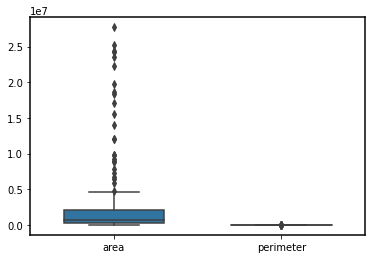

In [6]:

df1 = df[['area', 'perimeter']]
sbn.boxplot(data=df1, width=.6);

Scaling the features

<AxesSubplot:>

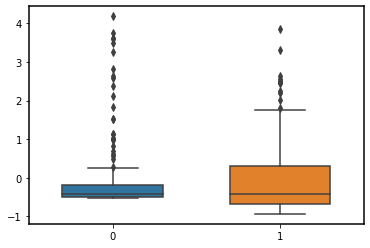

In [7]:
## fit scaler on data
scaler = preprocessing.StandardScaler().fit(df1)
df2 = scaler.transform(df1)
sbn.boxplot(data=df2, width=.6, fliersize=5)


/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


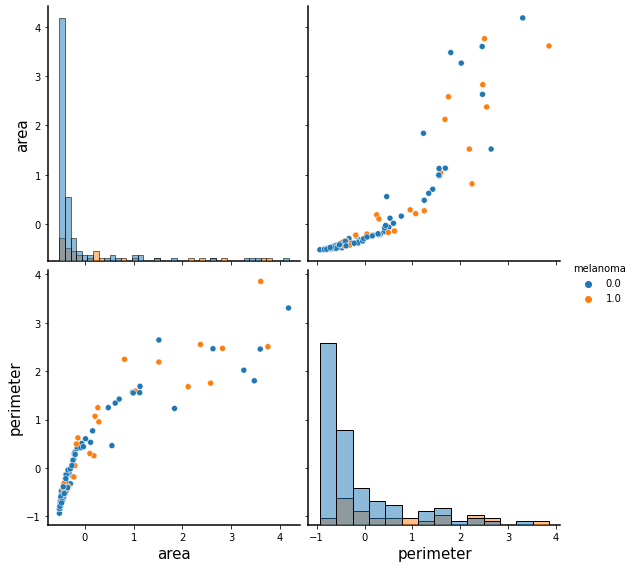

In [8]:
## looking at values per class 
df2 = pd.DataFrame(df2, columns=['area','perimeter'])
df2['melanoma'] = df['melanoma']
sbn.pairplot(data=df2, hue='melanoma', size=4, diag_kind='hist')

# Task 1

Feature seletion


In [9]:
#Creating separate lists for healthy and keratosis lesions, contains only the image_ids. Also resetting indexes
kera_list = Classification.loc[Classification.seborrheic_keratosis==1, :].image_id
kera_list = kera_list.reset_index(drop=True)
healthy_list = Classification.loc[Classification.seborrheic_keratosis==0, :].image_id
healthy_list = healthy_list.reset_index(drop=True)

In [10]:
#class containing the calculations for all of our features
class Lesion:
    # compactness, symmetry, colour
    def __init__(self, ID, im, seg, lesiontype=None, calcTexture=False):
        assert lesiontype in [0,1,2,None] # 0: keratosis, 1: healthy, 2: melanoma, None: unknown
        self.lesiontype = lesiontype 
        self.ID = ID
        self.im = im
        self.seg = seg
        
        # a,b = np.where(seg == 1)
        a,b = np.asarray(seg == 1).nonzero()

        self.bottom, self.top, self.leftmost, self.rightmost = max(a), min(a), min(b), max(b)
        self.center = (  (self.top+self.bottom) // 2  ,  (self.leftmost + self.rightmost) // 2  )
        # note the center is from the original, and not the cropped image
        
        margin = 50
        self.croppedSeg = self.seg[self.top-margin:self.bottom+margin, self.leftmost-margin:self.rightmost+margin]
        #im_part = im[60:120,130:220,:]
        
        self.area = np.sum(seg)

        self.perimeter = self.findPerimeter()

        # perimeter**2 / ( 4*pi*area )    // compactness
        self.compactness = (self.perimeter**2) / (4*np.pi*self.area)

        self.rgb = self.getRGBVectors()
        self.calcRGBStats() # self.lesionColorStats is now accessible (dictionary)

        if calcTexture:
            self.texture = self.edgeFlatCornerTexture()
        
    def plotRGBScatter(self):
        fig = plt.figure()
        axis = fig.add_subplot(1,1,1, projection ='3d')

        r,g,b = list(self.RGB[0]), list(self.RGB[1]), list(self.RGB[2])

        axis.scatter(r,g,b, c='#ff0000', marker='o', alpha=0.05)
        axis.set_xlabel('Red')
        axis.set_ylabel('Green')
        axis.set_zlabel('Blue')
        plt.show()
    def getRGBVectors(self):
        x,y = np.where(self.seg == 1)
        rgb = self.im[x,y,:].transpose()
        # rgb[0] = r, rgb[1] = g, rgb[2] = b
        return rgb
    def calcRGBStats(self):
        segmask = (self.seg > 0)
        image = img_as_float(self.im)
        # using superpixels doesn't add anything to the analysis, as the RGB averages calculated on the superpixels yield the same as RGB averages across the entire lesion... 
        segments = slic(image, compactness=6.0, mask=segmask, n_segments=50, sigma = 5, enforce_connectivity=True, multichannel=True,convert2lab=True)
        
#         print(len(segments[segmask])) # these correspond to the same pixels as rgb
#         print(len(rgb[0])) # these correspond to the same pixels as segments
        segmentCount = len(np.unique(segments[segmask]))
        rs = [[] for i in range(segmentCount)]
        gs = [[] for i in range(segmentCount)]
        bs = [[] for i in range(segmentCount)]
        for i, seg in enumerate(segments[segmask]):
            # holy cow... 
            try:
                rs[seg-1].append( self.rgb[0][i] ) # appends the r value of pixel i to it's segments list of r values in rs
                gs[seg-1].append( self.rgb[1][i] )
                bs[seg-1].append( self.rgb[2][i] )
            except Exception as e:
                print("!!! getRGBStats(), ID:",self.ID," some stuff went wrong, (i,seg): (", i,",",seg,")")
                print(e)
                break # would use exit(), but no worko in notebook
        # calculate average of each segment... 
        segmentAvgs = [[] for i in range(segmentCount)] # each list contains [avgRed, avgGreen, avgBlue]. index corresponds to segment.
#         print("---------")
        for i in range(segmentCount):
            segmentAvgs[i].append( np.asarray(rs[i]).mean() )
            segmentAvgs[i].append( np.asarray(gs[i]).mean() )
            segmentAvgs[i].append( np.asarray(bs[i]).mean() )
#         print(len(segmentAvgs))
        # for i in segmentAvgs: print(i)

        # okay, make segmentAvgs into a 2D ndarray, and then transpose it so there's 3 vectors of averages, then you can do statistics on 'em
        segAvgMat = np.asarray(segmentAvgs).transpose()
        # the stats on the averages are the same as the averages across the whole lesion, thus the superpixels (SLIC) doesn't add anything, but if one wanted to print a picture of the superpixels with the average color, then this matrix should be used. 
        
        self.SLICSegs = segments # for (perhaps) later use
        self.SLICSegRGBAverages = segAvgMat # for (perhaps) later use
        
        self.lesionColorStats = {"mean_red":segAvgMat[0].mean(), 
                                 "mean_green":segAvgMat[1].mean(), 
                                 "mean_blue":segAvgMat[2].mean(),
                                 "std_red":np.std(segAvgMat[0]),
                                 "std_green":np.std(segAvgMat[1]),
                                 "std_blue":np.std(segAvgMat[2])
                            }
        
    def printlocation(self):
        print("top:", self.top, "bottom:", self.bottom, "leftmost:", self.leftmost, "rightmost:", self.rightmost)
        
    def showCropSeg(self):
        plt.imshow(self.croppedSeg, cmap="gray")

    def findPerimeter(self, show=False):
        struct_el = morphology.disk(20)
        seg_eroded = morphology.binary_erosion(self.seg, struct_el)
        self.perimeterimg = self.seg - seg_eroded
        if show:
            self.compareSeg(self.perimeterimg)
        
        self.perimeter = np.sum(self.perimeterimg)
        return self.perimeter
    
    def compareSeg(self, im):
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 12))
        axes[0].imshow(self.seg, cmap='gray')
        axes[1].imshow(im, cmap='gray')
        fig.tight_layout()
        
    
    def edgeFlatCornerTexture(self, showgreyscale=False):
        radius = 3
        n_points = 8 * radius # Number of circularly symmetric neighbour set points
        METHOD = 'uniform'
        segmask = (self.seg[self.top-1:self.bottom+1, self.leftmost-1:self.rightmost+1] > 0)
        grayscale = rgb2gray(self.im[self.top-1:self.bottom+1, self.leftmost-1:self.rightmost+1])
        image = grayscale
        if showgreyscale:
            plt.imshow(grayscale)
        lbp = local_binary_pattern(image, n_points, radius, METHOD)
#         print(image.shape)
#         print(lbp.shape)
#         print("lbp.ravel()")
#         print(len(lbp[segmask].ravel()))
#         print("np hist")
        n_bins = int(lbp[segmask].max() + 1)
        hist_vals = np.histogram(lbp[segmask].ravel(), density=True, bins=n_bins, range=(0, n_bins))[0]
#         print(hist_vals)
        flatreg = np.concatenate((hist_vals[0:4],hist_vals[21:26])).sum()
        #flatreg = flatreg.sum()
        cornerreg = np.concatenate((hist_vals[4:9],hist_vals[15:20])).sum()
        #cornerreg = cornerreg.sum()
        edgereg = hist_vals[9:14].sum()
        #edgereg = edgereg.sum()
        
        return (flatreg, cornerreg, edgereg) # doesn't sum to 1 cuz not all bins are included...
        

In [11]:
#Function for creating the lesion objects based on image_id's
#Takes healthy_list,0 or kera_list,1 as input. 
def LesionCreator(lst, lesiontype):
    leslist = []
    
    for i in range(len(lst)):
        try:
            ID = lst[i]
            img = plt.imread(f"{BASE_DIR}example_image/{ID}.jpg")
            seg = plt.imread(f"{BASE_DIR}example_segmentation/{ID}_segmentation.png")
       
            les = Lesion(ID,img,seg,lesiontype, calcTexture=True)
            leslist.append(les)
        except Exception as e:
            print(f"Could not process image: {lst[i]}")
            print(e)
    return leslist

In [12]:
# Function used to compile and create the CSV files
def compileCSVFromLesionList(leslist, pathToCSV, includeTexture=False):
    IDs = []
    compacts = []
    stdred = []
    stdblue = []
    stdgreen = []
    flats = []
    corners = []
    edges = []
    lesiontype = []
    if includeTexture:
        for l in leslist: 
            IDs.append(l.ID)
            compacts.append(l.compactness)
            stdred.append(l.lesionColorStats["std_red"])
            stdblue.append(l.lesionColorStats["std_blue"])
            stdgreen.append(l.lesionColorStats["std_green"])
            flats.append(l.texture[0]) # flatness
            corners.append(l.texture[1]) # corner
            edges.append(l.texture[2]) # edge
            lesiontype.append(l.lesiontype)
    else:
        for l in leslist: 
            IDs.append(l.ID)
            compacts.append(l.compactness)
            stdred.append(l.lesionColorStats["std_red"])
            stdblue.append(l.lesionColorStats["std_blue"])
            stdgreen.append(l.lesionColorStats["std_green"])
            lesiontype.append(l.lesiontype)

    d = {'ID': IDs, 'compactness': compacts, "red_std":stdred, "green_std":stdgreen, 
        "blue_std":stdblue, "lesiontype":lesiontype}
    if includeTexture:
        d["flatness"] = flats
        d["cornerness"] = corners
        d["edgeness"] = edges
    
    if not len(IDs) == len(compacts):
        print("!!! lengths not equal !!!")
        print(len(IDS))
        print(len(compacts))

    df = pd.DataFrame(data=d)
    df.to_csv(pathToCSV)

In [13]:
#Since the processing was quite labour intensive we ran it locally and compiled it to csv
# read data into one dataframe (and write to one csv)
# d1 = pd.read_csv("healty_data_0_to_50.csv")
# d2 = pd.read_csv("kera_0_to_50.csv")
# d3 = pd.read_csv("healty_data_50_to_100.csv")
# d4 = pd.read_csv("healty_data_100_to_150.csv")
# d5 = pd.read_csv("kera_50_to_100.csv")
# d6 = pd.read_csv("kera_100_to_150.csv")
# d7 = pd.read_csv("kera_150_to_200.csv")
# d8 = pd.read_csv("healty_data_150_to_200.csv")
# feature_measurements = pd.concat([d1, d2, d3, d4, d5, d6])
feature_measurements = pd.read_csv("lesiondata.csv")

#data.to_csv("lesiondata.csv", index=False)    #### EXECUTE THIS AT SOME POINT YALLAH



The scatter plots below show the data points for the healthy/keratosis lesions. The orange dots represent the entries for the healthy skin, while the blue ones are for the non-healthy. The plots suggest that the healthy lesions are more compact compared with the keratosis lesions. On the other hand, the keratosis lesions tend to have bigger values when it comes to edgeness, flatness, cornerness and RGB colors. 

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


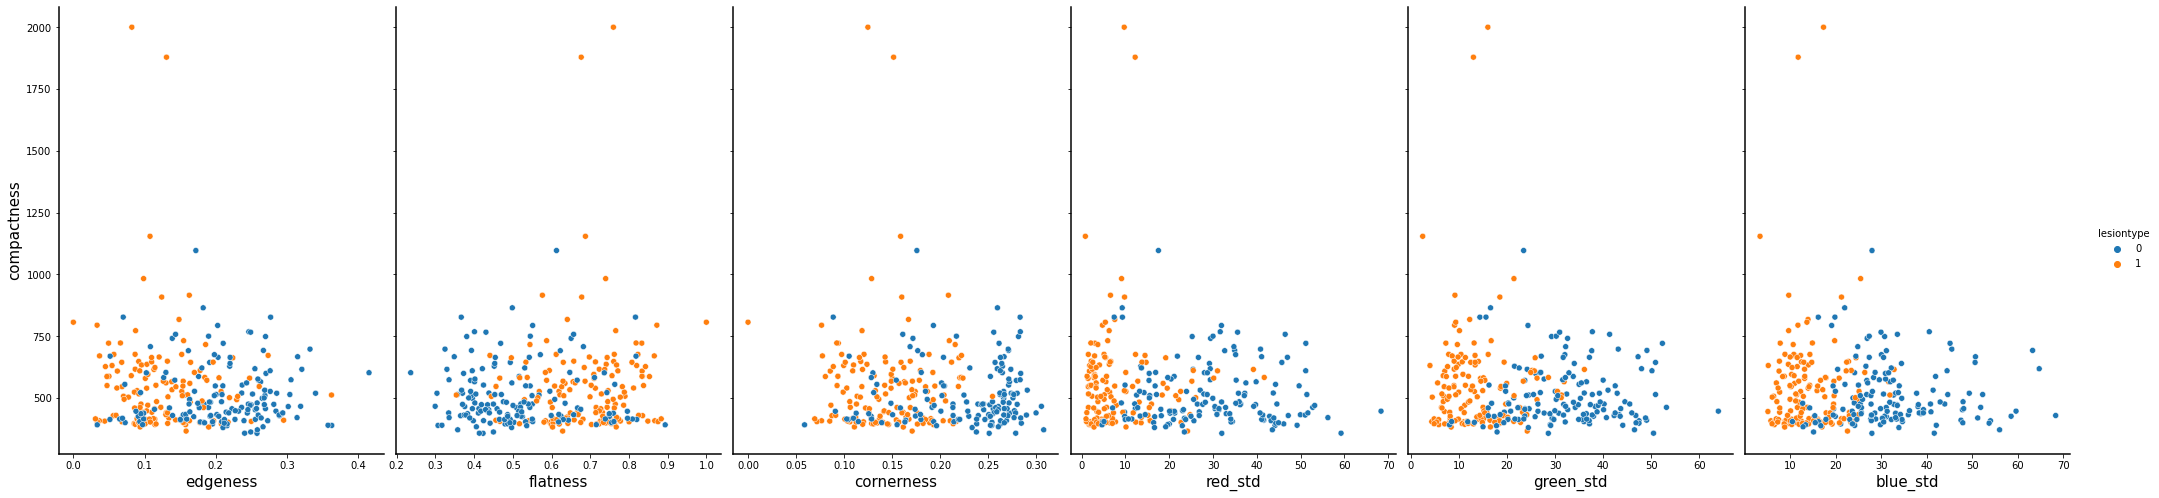

In [14]:
#Scatterplots of the feature measurements to see the distribution of the class
### Feature plotting
feature_measurements
pairplot = sbn.pairplot(feature_measurements, x_vars=['edgeness', 'flatness','cornerness', 'red_std', 'green_std', 'blue_std'], y_vars='compactness', hue='lesiontype', size=7, aspect=.7)
pairplot.axes[0,0].set(xlabel='edgeness')
pairplot.axes[0,0].set(ylabel='compactness')
pairplot.axes[0,1].set(xlabel='flatness');



# Task 2

In [15]:
#Setting up the target as well as the features. In line with our research questions we want to see how well the model predicts the diagnoses 
#with the different feature measurements
target = feature_measurements["lesiontype"]
features_only_color = feature_measurements[["red_std", "green_std", "blue_std"]]
features_only_compactness = feature_measurements[["compactness"]]
features_only_texture = feature_measurements[["flatness", "cornerness", "edgeness"]]
features_with_texture = feature_measurements[["compactness", "red_std", "green_std", "blue_std", "flatness", "cornerness", "edgeness"]]


In [19]:
#Function for calculating the confusion matrix, specificity and sensitivity
def con_spec_sen(preds, trues):
    confusion = metrics.confusion_matrix(trues, preds)
    # saving counts of true pos, true neg, false pos, false neg
    TP = confusion[1,1]
    TN = confusion[0,0]
    FP = confusion[0,1]
    FN = confusion[1,0]
    accuracy = (TP+TN) / float( TP+TN+FP+FN )
    sensitivity = TP / float(TP+FN)
    specificity = TN / float(TN + FP)

    return {"accuracy":accuracy, "sensitivity":sensitivity, "specificity":specificity}




#Function for training the model
def modelTuning(target, features, title):
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=4) 
    # finding best k in KNN
    k_max = 30 
    k_range = range(1,k_max)
    acc_scores = []
    sensitivities = [] # SENSITIVITY - When the actual value is positive, how often is the prediction correct
    specificities = [] # SPECIFICITY - When the actual value is negative, how often is the prediction correct? 

    # IMPORTANT: the sensitivity and specificity are inverted, given that lesiontype 0 is keratosis and lesiontype 1 is healthy. 
    # i.e. sensitivity is how often it correctly predicts a healthy lesion
    #      and specificity is how often it correctly predicts a keratosis lesion

    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        acc_scores.append(metrics.accuracy_score(y_test, y_pred))
        # sensitivity and specificity
        spec_sen = con_spec_sen(y_pred, y_test)
        sensitivities.append(spec_sen["sensitivity"])
        specificities.append(spec_sen["specificity"])
    cross_scores = [] # cross val
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, features, target, cv=10, scoring="accuracy")
        cross_scores.append(scores.mean())
    
    fig, axs = plt.subplots(2,2, figsize=(10,12))
    fig.suptitle(title)
    axs[0][0].plot(k_range, acc_scores)
    axs[0][0].set_title("Accuracy score")
    axs[0][0].set_xlabel("Value of K for KNN")
    axs[0][0].set_ylabel("Accuracy score")

    axs[0][1].plot(k_range, cross_scores) 
    axs[0][1].set_title("Cross validated accuracy")
    axs[0][1].set_xlabel("Value of K for KNN")
    axs[0][1].set_ylabel("Cross validated accuracy")

    axs[1][0].plot(k_range, specificities) 
    axs[1][0].set_title("Specificity")
    axs[1][0].set_xlabel("Value of K for KNN")
    axs[1][0].set_ylabel("Specificity score")

    axs[1][1].plot(k_range, sensitivities) 
    axs[1][1].set_title("Sensitivity")
    axs[1][1].set_xlabel("Value of K for KNN")
    axs[1][1].set_ylabel("Sensitivity score")
    fig.show()
    print(spec_sen)




{'accuracy': 0.8194444444444444, 'sensitivity': 0.7368421052631579, 'specificity': 0.9117647058823529}


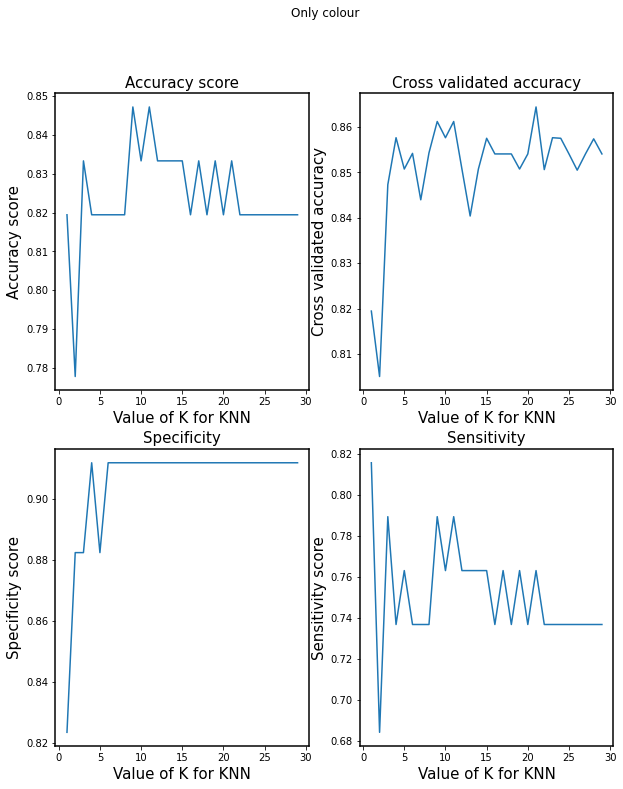

In [20]:
#Following our first research question we train the model with only the colour measurements
#From this we get a model with a cross validated accuracy in the 80th percentile range
modelTuning(target, features_only_color, "Only colour")

{'accuracy': 0.4583333333333333, 'sensitivity': 0.5789473684210527, 'specificity': 0.3235294117647059}


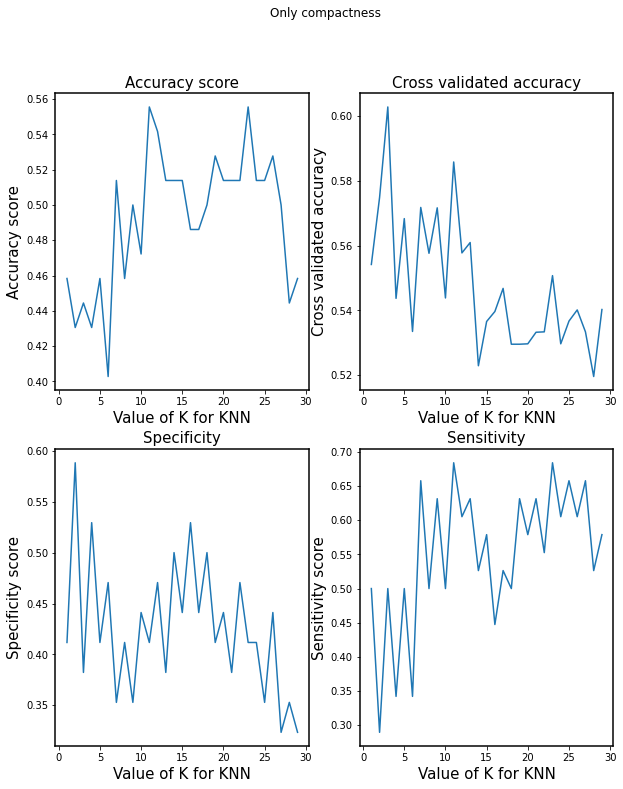

In [21]:
#Following our second research question we train the model with only the border measurements i.e. compactness
#Here we see a far worse accuracy than the previous model, with a cross validated accuracy in the 50th percentile range
modelTuning(target, features_only_compactness, "Only compactness")

# Task 3

{'accuracy': 0.8611111111111112, 'sensitivity': 0.868421052631579, 'specificity': 0.8529411764705882}


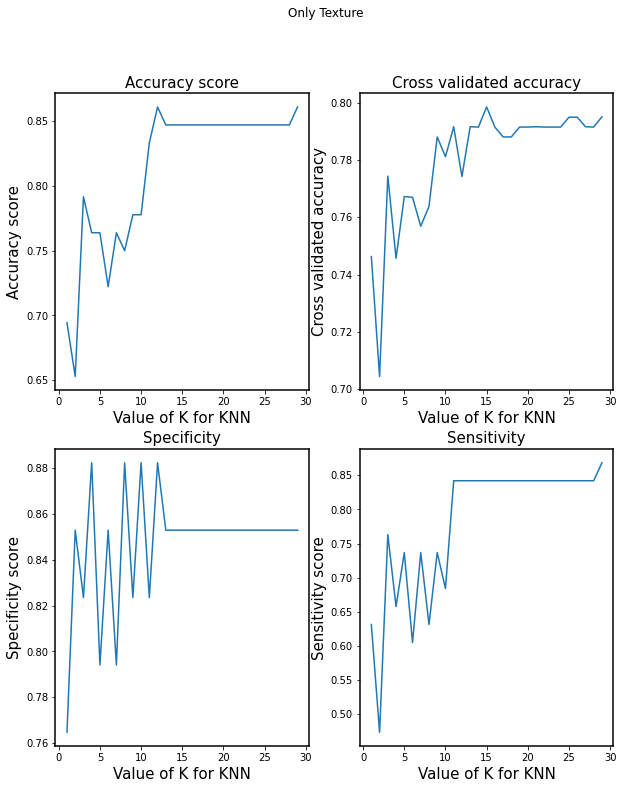

In [22]:
#Following our third research question (open question) we train the model with only the texture measurements
#We also wanted to explore features outside of the "ABC". Therefore, we train a model using texture measurements.
#Here we see a result of a cross validated accuracy in the the 70th percentile range
modelTuning(target, features_only_texture, "Only Texture")

{'accuracy': 0.7222222222222222, 'sensitivity': 0.8421052631578947, 'specificity': 0.5882352941176471}


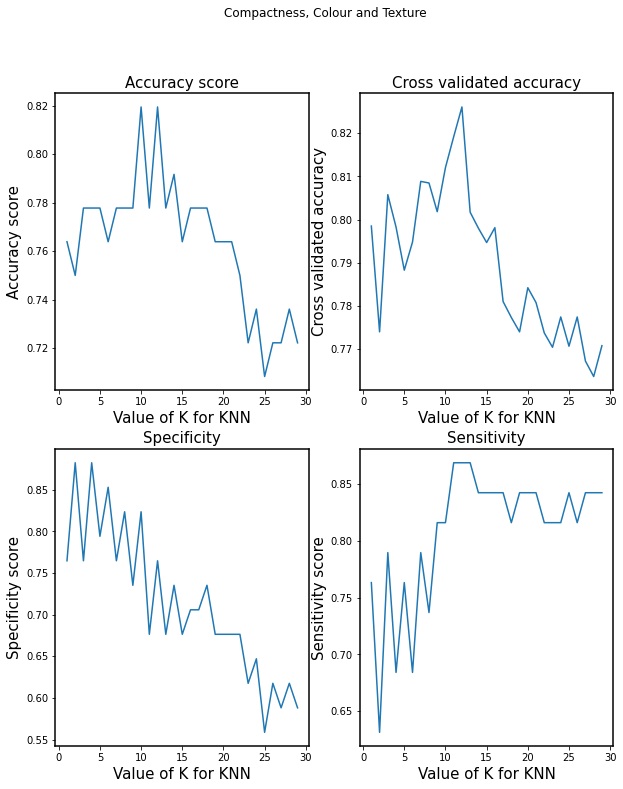

In [23]:
#We also wanted to investigate how well the model would predict the diagnoses when fed with all of our feature measurements.
#Here we get a model that has a good accuracy, however it performs worse than the model that was just trained with the colour measurements
modelTuning(target, features_with_texture, "Compactness, Colour and Texture")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a22c90a7-6abc-4bdc-963d-b3e97348d97c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>